In [1]:
import random
from torchvision.utils import make_grid, save_image
from diffusers import DDPMScheduler, DDIMScheduler
import joblib
import scipy.sparse as sp
from PIL import Image
import matplotlib.pyplot as plt
import wandb
from dataclasses import dataclass
import numpy as np
from natsort import natsorted
import math, os, glob, torch
from torch.utils.data import Dataset, DataLoader
from scipy import sparse
import torch.nn.functional as F
from pathlib import Path
from diffusers import DDPMScheduler
import torchvision.transforms as T

/home/dantle/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
filename = '/home/dantle/CacheBox/cache_heatmap_diffusion_model_fullmisspairs_20train.sav' 
model = joblib.load(open(filename, 'rb'))
print("# of in channels: ", model.config.in_channels)
print("# of out channels: ", model.config.out_channels)

# of in channels:  2
# of out channels:  1


In [3]:
root = Path("/home/pranjali_jain/NCS/sparse-matrices/SPEC/SPEC189_2config/1-64-12/TEST")
test_benchmarks = ["403.gcc-16B", "445.gobmk-2B", "450.soplex-92B", "465.tonto-44B"]

for i in range(len(test_benchmarks)):
    print(len(os.listdir(str(root / "MISS" / test_benchmarks[i]))))


5529
8477
5658
9319


In [4]:
# import torchvision.transforms as T

# wandb.init(project="CacheBoxDModel", entity="dantle4564-uc-santa-barbara", name="diffusion images")

# scheduler = DDPMScheduler(num_train_timesteps=1000)

# # generate only one image
# num = 1
# model.eval()
# device = torch.device("cuda")

# image_size = 512

# with torch.no_grad():
#     x = torch.randn(num, 3, image_size, image_size, device=device)
#     scheduler.set_timesteps(scheduler.config.num_train_timesteps)
#     for i,t in enumerate(scheduler.timesteps):
#         with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
#             model_input = scheduler.scale_model_input(x, t)
#             noise_pred = model(model_input, t).sample
#             x = scheduler.step(noise_pred, t, x).prev_sample
#             if i % 10 == 0: 
#                 img = (x.clamp(-1, 1) + 1) / 2  # scale to [0,1]
#                 img_np = T.ToPILImage()(img[0].cpu())
#                 wandb.log({f"Time step {i}" : wandb.Image(img_np)})
        
#     # save the single image
#     img = (x.clamp(-1, 1) + 1) / 2
#     print(img.type)
#     print("Image shape:" , img.shape)
#     arr0 = img[0]                          # (3, H, W)
#     arr0_cpu = arr0.detach().cpu().numpy()
#     print("Image shape: ", arr0_cpu.shape)

#     H, W = arr0_cpu.shape[1], arr0_cpu.shape[2]
#     mat2d = arr0_cpu.reshape(3, H * W).T       # (H*W, 3)
#     sparse_mat = sparse.csr_matrix(mat2d)
#     sparse.save_npz("fakeB/synthetic_heatmap.npz", sparse_mat)


In [5]:
from skimage.metrics import structural_similarity as ssim
data1 = sp.load_npz("/home/dantle/CacheBox/fakeB/400.perlbench-41B/400.perlbench-41B.champsimtrace.xz.txt_67_fakeB.npz")
data2 = sp.load_npz("/home/dantle/CacheBox/fakeB/400.perlbench-41B/400.perlbench-41B.champsimtrace.xz.txt_420_fakeB.npz")

# print(data1.files)
# print(data2.files)
print(type(data1))
print(data1.shape)
print(data1.nnz)
img1 =  np.array(data1.toarray(), dtype = np.uint8)
print(data2.shape)
print(data2.nnz)
img2 = np.array(data2.toarray(), dtype = np.uint8)
print("Shape 1:", img1.shape)
print("Shape 2:", img2.shape)


score, diff = ssim(img1, img2, full=True)

print("SSIM:", score)



<class 'scipy.sparse._csr.csr_matrix'>
(512, 512)
2649
(512, 512)
2647
Shape 1: (512, 512)
Shape 2: (512, 512)
SSIM: 0.9995940609225156


In [6]:
# import numpy as np
# from scipy.sparse import load_npz
# from skimage.metrics import structural_similarity as ssim
# from skimage.transform import resize

# # ---- 1. Load sparse test heatmap and make it dense ----
# test_sp = load_npz("/home/pranjali_jain/NCS/sparse-matrices/SPEC/SPEC189_2config/1-64-12/TEST/MISS/400.perlbench-41B/400.perlbench-41B.champsimtrace.xz.txt_73_B.npz")    # your existing .npz
# test_img = test_sp.toarray().astype(np.float32)  # shape: (512, 512)

# # ---- 2. Load your synthetic dense heatmap ----
# data = np.load("/home/dantle/CacheBox/fakeB/400.perlbench-41B/400.perlbench-41B_2_fakeB.npz")
# # adjust key as needed:
# synthetic = list(data.values())[0]               # or data["heatmap"]

# # If synthetic came from (1, 3, 128, 128) torch tensor:
# if synthetic.ndim == 4:
#     # (1, 3, 128, 128) -> (3, 128, 128)
#     synthetic = synthetic.squeeze(0)

# if synthetic.ndim == 3:
#     # collapse channels to grayscale (3, H, W) -> (H, W)
#     synthetic = synthetic.mean(axis=0)

# # Now synthetic is (H, W), probably (128, 128)

# # ---- 3. Resize synthetic to match (512, 512) ----
# synthetic_resized = resize(
#     synthetic, 
#     test_img.shape,       # (512, 512)
#     anti_aliasing=True
# ).astype(np.float32)

# print(test_img.shape)
# # print(test_img)
# print(synthetic_resized.shape)
# # ---- 4. Compute SSIM ----
# score, diff = ssim(test_img, synthetic_resized, full=True, data_range=1.0)
# print("SSIM:", score)


In [7]:
# colormap = 'magma_r' #'PuOr'#
# plt.style.use('seaborn-v0_8-deep')
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.serif'] = ['Helvetica']
# Fontsize = 20
# plt.rcParams['font.size'] = Fontsize

# plt.rcParams['axes.facecolor'] = 'white'  
# plt.rcParams['text.color'] = 'black'  
# plt.rcParams['axes.labelcolor'] = 'black'  
# plt.rcParams['xtick.color'] = 'black' 
# plt.rcParams['ytick.color'] = 'black'  
# plt.rcParams['axes.edgecolor'] = 'black'  
# plt.rcParams['axes.linewidth'] = 1.0
# plt.rcParams['legend.handlelength'] = 0.7
# plt.rcParams['legend.handleheight'] = 0.7
# plt.rcParams['ytick.major.size'] = 4
# plt.rcParams['ytick.major.width'] = 1

# stepval = 256

# figure, (ax1) = plt.subplots(1,1, figsize=(5, 5))
# figure.patch.set_facecolor("white")


# ax1.imshow(test_img, cmap=colormap)
# # ax1.axis('off')
# # ax1.set_title('Real full map')
# ax1.set_xticks(ticks = np.arange(0, 513, step=stepval))
# ax1.set_yticks(ticks = np.arange(0, 513, step=stepval))
# plt.xticks(fontsize=Fontsize-2)
# plt.yticks(fontsize=Fontsize-2)
# plt.ylabel('cacheline address\nmodulo 512',labelpad=8)
# plt.xlabel('Instructions',labelpad=8)
# plt.tight_layout()
# # plt.savefig("Graphs/heatmap_1x1_realfull", dpi=300, bbox_inches='tight', pad_inches=0)
# plt.show()

In [8]:
# colormap = 'magma_r' #'PuOr'#
# plt.style.use('seaborn-v0_8-deep')
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.serif'] = ['Helvetica']
# Fontsize = 20
# plt.rcParams['font.size'] = Fontsize

# plt.rcParams['axes.facecolor'] = 'white'  
# plt.rcParams['text.color'] = 'black'  
# plt.rcParams['axes.labelcolor'] = 'black'  
# plt.rcParams['xtick.color'] = 'black' 
# plt.rcParams['ytick.color'] = 'black'  
# plt.rcParams['axes.edgecolor'] = 'black'  
# plt.rcParams['axes.linewidth'] = 1.0
# plt.rcParams['legend.handlelength'] = 0.7
# plt.rcParams['legend.handleheight'] = 0.7
# plt.rcParams['ytick.major.size'] = 4
# plt.rcParams['ytick.major.width'] = 1

# stepval = 256

# figure, (ax1) = plt.subplots(1,1, figsize=(5, 5))
# figure.patch.set_facecolor("white")


# ax1.imshow(synthetic_resized, cmap=colormap)
# # ax1.axis('off')
# # ax1.set_title('Real full map')
# ax1.set_xticks(ticks = np.arange(0, 513, step=stepval))
# ax1.set_yticks(ticks = np.arange(0, 513, step=stepval))
# plt.xticks(fontsize=Fontsize-2)
# plt.yticks(fontsize=Fontsize-2)
# plt.ylabel('cacheline address\nmodulo 512',labelpad=8)
# plt.xlabel('Instructions',labelpad=8)
# plt.tight_layout()
# # plt.savefig("Graphs/heatmap_1x1_realfull", dpi=300, bbox_inches='tight', pad_inches=0)
# plt.show()

In [ ]:


test_benchmarks = ["400.perlbench-41B"]
# test_benchmarks = ["403.gcc-16B", "445.gobmk-2B", "450.soplex-92B", "465.tonto-44B"]

for i in range(len(test_benchmarks)):
    print(len(os.listdir(str(root / "MISS" / test_benchmarks[i]))))

file_len = len(os.listdir(str(root / "MISS" / test_benchmarks[0])))


5529
8477
5658
9319


In [ ]:
full_root = Path("/home/pranjali_jain/NCS/sparse-matrices/SPEC/SPEC189_2config/1-64-12/TEST/FULL")
miss_root = Path("/home/pranjali_jain/NCS/sparse-matrices/SPEC/SPEC189_2config/1-64-12/TEST/MISS")
fake_root = Path("/home/dantle/CacheBox/fakeBv3")

# wandb.init(project="CacheBoxDModel", entity="dantle4564-uc-santa-barbara", name="diffusion images")

scheduler = DDIMScheduler(num_train_timesteps=50)
num_inference_steps = 50

# generate only one image
num_images = file_len
num = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
image_size = 512


In [11]:
# helper function to convert vector shapes to proper squares
def vector_to_square(x1d):
    L = x1d.shape[0]
    s = int(math.ceil(math.sqrt(L)))
    out = np.zeros(s*s, dtype=x1d.dtype)
    out[:L] = x1d
    return out.reshape(s, s)

In [12]:
# helper function to load full heatmaps
def load_full_npz_to_tensor(path, image_size=512):
    with np.load(path, allow_pickle=False) as npz:
        k = "arr_0" if "arr_0" in npz.files else next(
            kk for kk in npz.files if isinstance(npz[kk], np.ndarray)
        )
        x = np.array(npz[k], dtype=np.float32)

    # same shape handling you used in the dataset
    if x.ndim == 1:
        x = vector_to_square(x)
    elif x.ndim > 2:
        x = x[0]

    xmin, xmax = np.min(x), np.max(x)
    x = (x - xmin) / (xmax - xmin) if xmax > xmin else np.zeros_like(x, dtype=np.float32)

    x = torch.from_numpy(x)
    if x.ndim == 2:
        x = x.unsqueeze(0)

    x = F.interpolate(
        x.unsqueeze(0),
        size=(image_size, image_size),
        mode="bilinear",
        align_corners=False,
    ).squeeze(0)

    x = x * 2 - 1  # [-1, 1] like training
    return x  # [1, H, W]


In [13]:
import csv
csv_path = "inference_time.csv"

def write_result(trace_name, hit_rate):
    header = ["num_steps", "inference_time_sec"]
    exists = os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        writer = csv.writer(f)
        if not exists:
            writer.writerow(header)
        writer.writerow([trace_name, hit_rate])

In [ ]:
# import torchvision.transforms as T
# import time


# # wandb.init(project="CacheBoxDModel", entity="dantle4564-uc-santa-barbara", name="diffusion images")

# num_steps = [50, 100, 500, 1000]

# for step in num_steps:

#         scheduler = DDPMScheduler(num_train_timesteps=step)

#         # generate only one image
#         num = 1
#         model.eval()
#         device = torch.device("cuda")

#         image_size = 512


#         with torch.no_grad(), torch.autocast("cuda"):
#                 full = load_full_npz_to_tensor("/home/dantle/CacheBox/FULL_DATASET/TEST/FULL/400.perlbench-41B/400.perlbench-41B.champsimtrace.xz.txt_0_A.npz", image_size=512).unsqueeze(0).to(device)
#                 miss = torch.randn_like(full)
#                 scheduler.set_timesteps(scheduler.config.num_train_timesteps,device=device)
#                 start = time.time()
#                 for i,t in enumerate(scheduler.timesteps):
#                         model_input = torch.cat([miss, full], dim=1)
#                         # model_input = miss
#                         noise_pred = model(model_input, t, return_dict=False)[0]
#                         miss = scheduler.step(noise_pred, t, miss).prev_sample
#                         # if t % 10 == 0: 
#                         #     img = (miss.clamp(-1, 1) + 1) / 2  # scale to [0,1]
#                         #     img_np = T.ToPILImage()(img[0].cpu())
#                         #     wandb.log({f"Time step {i}" : wandb.Image(img_np)})
#                 end = time.time()
#                 elapsed_time = end - start
#                 print(f"Execution time: {elapsed_time:.4f} seconds")
#                 write_result(step, elapsed_time)
    
   

Execution time: 9.8858 seconds
Execution time: 19.0722 seconds
Execution time: 95.4221 seconds
Execution time: 190.8247 seconds


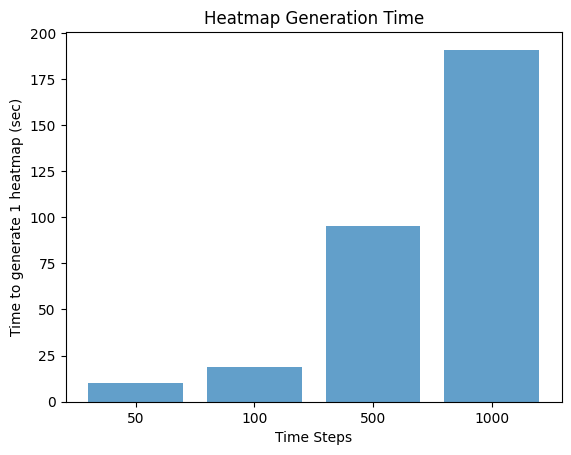

In [21]:
import matplotlib.pyplot as plt

# Data
num_steps = [50, 100, 500, 1000]
inference_time_sec = [9.885757207870483,
                      19.072179079055786,
                      95.42207741737366,
                      190.82468247413635]

# Plot
# Create positions for the bars on the x-axis
x_pos = np.arange(len(num_steps))

# Create the bar chart
plt.bar(x_pos, inference_time_sec, align='center', alpha=0.7)

# Add labels and title
plt.xticks(x_pos, num_steps)  # Set x-axis tick labels
plt.ylabel('Time to generate 1 heatmap (sec)')
plt.xlabel('Time Steps')
plt.title('Heatmap Generation Time')

# Display the chart
plt.savefig('inference_time.png')


In [ ]:
#  # save the single image
# img = (miss.clamp(-1, 1) + 1) / 2
# print(img.type)
# print("Image shape:" , img.shape)
# arr0 = img[0].detach().cpu().numpy()
# arr2d = arr0[0]
# # arr0 = img[0]                          # (3, H, W)

# # Option A: pixels as rows, channels as cols -> (H*W, 3)     # (H*W, 3)
# sparse_mat = sparse.csr_matrix(arr2d)
# sparse.save_npz("synthetic_heatmap.npz", sparse_mat)

<built-in method type of Tensor object at 0x7f8f3f839a40>
Image shape: torch.Size([1, 1, 512, 512])


In [ ]:
# full_files = natsorted(os.listdir((full_root) + "/" +  test_benchmarks[0]))

# full_path = str(full_root / test_benchmarks[0] / full_files[0] )
# full = load_full_npz_to_tensor(full_path, 512)
# print("full tensor shape:", full.shape)  # should be [1, 512, 512]

# full_batched = full.unsqueeze(0)
# miss = torch.randn_like(full_batched)
# model_input = torch.cat([miss, full_batched], dim=1)
# print("model_input shape:", model_input.shape)  # should be [1, 2, 512, 512]

# out = model(model_input, torch.tensor([0], device=device), return_dict=False)[0]
# print("model output shape:", out.shape)  # should be [1, 1, 512, 512]


TypeError: unsupported operand type(s) for +: 'PosixPath' and 'str'

In [ ]:
def generate_miss(full_path):
    full = load_full_npz_to_tensor(full_path, image_size=512).unsqueeze(0).to(device)
    miss = torch.randn_like(full)
    scheduler.set_timesteps(num_inference_steps, device=device)
    with torch.no_grad(), torch.autocast("cuda"):
        for t in scheduler.timesteps:
            model_input = torch.cat([miss, full], dim=1)
            # model_input = miss
            noise_pred = model(model_input, t, return_dict=False)[0]
            miss = scheduler.step(noise_pred, t, miss).prev_sample
    
    img = (miss.clamp(-1, 1) + 1) / 2.0  
    arr0 = img[0].detach().cpu().numpy()  
    # print(arr0.shape)

    # print(arr0.shape)
    arr2d = arr0[0]
    # print(arr2d.shape)
    assert arr2d.shape == (512, 512)

    return arr2d
    # sparse_mat = sparse.csr_matrix(mat2d)
    # sparse.save_npz(str(fake_path) , sparse_mat)


In [30]:
name = "400.perlbench-50B.champsimtrace.xz.txt_47_A.npz"
name.split(".champsimtrace.xz.txt_")[1].split("_A.npz")[0]

'47'

In [ ]:
# print("DEBUG: model.config.in_channels:", model.config.in_channels)
# print("DEBUG: conv_in weight shape:", model.conv_in.weight.shape)

# full_files = natsorted([p for p in os.listdir(str(full_root / "400.perlbench-41B")) if p.endswith("_A.npz")])
# # Build a dummy input the same way you do in generate_miss
# full = load_full_npz_to_tensor(str(full_root / test_benchmarks[0] / full_files[0]), 512).unsqueeze(0).to(device)
# miss = torch.randn_like(full)
# model_input = torch.cat([miss, full], dim=1)

# print("DEBUG: model_input shape:", model_input.shape)

# # safety check
# assert model_input.shape[1] == model.config.in_channels, \
#     f"Input channels {model_input.shape[1]} != model.in_channels {model.config.in_channels}"


In [ ]:
def sparse_matrix(mat, density=0.01):
    mat = np.clip(mat, 0.0, 1.0)
    curr_mean = float(mat.mean())
    scale = density/curr_mean
    prob = np.clip(mat * scale, 0.0, 1.0)
    sparse = np.random.default_rng().binomial(n=1,p=prob).astype(np.float32)
    return sparse



In [ ]:
# loop thru each benchmark to generate heatmap
full_root = Path("/home/pranjali_jain/NCS/sparse-matrices/SPEC/SPEC189_2config/1-64-12/TEST/FULL")
for bench in test_benchmarks:
    print("BENCH: ", bench)
    full_files = natsorted([p for p in os.listdir(str(full_root / bench)) if p.endswith("_A.npz")])[:1000]
    # print(len(full_files))
    # print(full_files[0:3])
    if not os.path.exists(str(fake_root / bench)): os.makedirs(str(fake_root / bench))
    output_path = str(fake_root / bench)
    for full_heatmap in full_files:
        # get index of heatmap
        idx = full_heatmap.split(".champsimtrace.xz.txt_")[1].split("_A.npz")[0] 
        # f"{bench}.champsimtrace.xz.txt.{idx}_fakeB.npz"
        full_path = str(full_root / bench / full_heatmap)
        mat2d = generate_miss(full_path)
        # sparse_fake = sparse_matrix(mat2d, density=0.01)
        sparse_mat = sparse.csr_matrix(mat2d)
        sparse.save_npz(str(output_path) + "/" + f"{bench}.champsimtrace.xz.txt_{idx}_fakeB.npz", sparse_mat)


NameError: name 'vector_to_square' is not defined

In [55]:
arr = np.load("synthetic_heatmap.npz")
print(arr.files)
print("Indices:", arr['indices'])
# print("indptr: ", arr['indptr'])
print("format: ", arr['format'])
print("shape: ", arr['shape'])
print("data: ", arr['data'])
print(arr['data'].mean())

arr = sp.load_npz("/home/dantle/CacheBox/FULL_DATASET/TEST/MISS/400.perlbench-41B/400.perlbench-50B.champsimtrace.xz.txt_3_B.npz")
# print(arr.files)
# print("Indices:", arr['indices'])
# print("indptr: ", arr['indptr'])
# print("format: ", arr['format'])
#print("shape: ", arr['shape'])
# print(arr)
print(arr.mean())
# print("data: ", arr['data'])
# print(arr['data'].mean())

['indices', 'indptr', 'format', 'shape', 'data']
Indices: [  0   1   2 ... 509 510 511]
format:  b'csr'
shape:  [512 512]
data:  [0.34303302 0.34215084 0.3319659  ... 0.20579255 0.2131331  0.21081007]
0.7632203
0.000164031982421875


In [26]:
arr = np.load("fakeBv2/403.gcc-16B/403.gcc-16B.champsimtrace.xz.txt_14_fakeB.npz")
binary = np.where(arr['data'] >= 0.5, 1.0, 0.0)
print(binary.mean())


0.504856015946393


In [ ]:
wandb.init("dantle4564-uc-santa-barbara")

In [27]:
import numpy as np

def redistribute_accesses(real_counts, heatmap):
    """
    real_counts: int array of shape (H, W), counts of real accesses
    heatmap:     float array of shape (H, W), >= 0 (e.g., model scores)

    Returns: predicted_counts with same total sum as real_counts,
             but distributed according to the heatmap.
    """
    real_counts = np.asarray(real_counts)
    heatmap = np.asarray(heatmap, dtype=np.float64)

    total_accesses = int(real_counts.sum())

    # If no real accesses, return all zeros
    if total_accesses == 0:
        return np.zeros_like(real_counts, dtype=int)

    # Make heatmap non-negative
    heatmap = np.maximum(heatmap, 0.0)

    # If heatmap is all zero, fallback to uniform distribution
    hm_sum = heatmap.sum()
    if hm_sum == 0:
        prob = np.full(heatmap.size, 1.0 / heatmap.size)
    else:
        prob = (heatmap / hm_sum).ravel()

    # Sample counts according to heatmap distribution
    sampled_flat = np.random.multinomial(total_accesses, prob)
    sampled = sampled_flat.reshape(heatmap.shape)
    return sampled


In [30]:
def sum_values(path, start_col, isFirst=False):
    sparse_matrix = (sp.load_npz(path)).tocsr()
    if isFirst: start_col = 0  
    sparse_matrix_subset = sparse_matrix[:, start_col:]
    return sparse_matrix_subset.sum()

In [57]:
real_counts = sum_values("synthetic_heatmap.npz", 0)
print(real_counts)

200073.6


In [61]:
real_counts = sum_values("/home/dantle/CacheBox/FULL_DATASET/TEST/MISS/400.perlbench-50B/400.perlbench-50B.champsimtrace.xz.txt_0_B.npz", 0)
print(real_counts)

303


In [2]:
real_root = "/home/pranjali_jain/NCS/sparse-matrices/SPEC/SPEC189_2config/1-64-12/TEST/MISS"
fake_root = "/home/dantle/CacheBox/fakeBv2"

In [5]:
from natsort import natsorted
import os
fakes = natsorted(os.listdir(fake_root + "/" + "400.perlbench-41B"))[:3]
print(fakes)

['400.perlbench-41B.champsimtrace.xz.txt_0_fakeB.npz', '400.perlbench-41B.champsimtrace.xz.txt_1_fakeB.npz', '400.perlbench-41B.champsimtrace.xz.txt_2_fakeB.npz']


In [10]:
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim
import scipy.sparse as sp
real_root = "/home/pranjali_jain/NCS/sparse-matrices/SPEC/SPEC189_2config/1-64-12/TEST/MISS"
fake_root = "/home/dantle/CacheBox/fakeB"
test_benchmarks = os.listdir(fake_root)
for bench in test_benchmarks:
    ssim_sum = 0
    mse_sum = 0
    fakes = natsorted(os.listdir(fake_root + "/" + bench))[:1000]
    reals = natsorted(os.listdir(real_root + "/" + bench))[:1000]
    for idx in range(len(fakes)):
        fake_heat = sp.load_npz(fake_root + "/" + bench + "/" + fakes[idx]).toarray()
        real_heat = sp.load_npz(real_root + "/" + bench + "/" + reals[idx]).toarray()
        mse_sum += mse(real_heat, fake_heat)
        ssim_sum += ssim(real_heat, fake_heat, data_range=1.0)
    print("Benchmark: ", bench)
    print(f"Average MSE of {bench}: ", mse_sum/1000)
    print(f"Average SSIM of {bench}: ", ssim_sum/1000)

Benchmark:  403.gcc-16B
Average MSE of 403.gcc-16B:  0.12584874725341796
Average SSIM of 403.gcc-16B:  0.18746338117731504
Benchmark:  465.tonto-44B
Average MSE of 465.tonto-44B:  0.014633018493652344
Average SSIM of 465.tonto-44B:  0.5741251632595348
Benchmark:  450.soplex-92B
Average MSE of 450.soplex-92B:  0.04665596008300781
Average SSIM of 450.soplex-92B:  0.3247827272703148
Benchmark:  445.gobmk-2B
Average MSE of 445.gobmk-2B:  0.013594375610351563
Average SSIM of 445.gobmk-2B:  0.5643316326769777
Benchmark:  400.perlbench-41B
Average MSE of 400.perlbench-41B:  0.010896415710449218
Average SSIM of 400.perlbench-41B:  0.5992744832008992
